<p align="center">
  <img width="421" alt="logo" src="https://user-images.githubusercontent.com/76659596/113596851-2e5cc280-963b-11eb-8526-fb8fca9c837e.png">
</p>

#### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

#### Import Dataset

In [2]:
dataset = pd.read_excel(
                '../data/sentences_with_sentiment.xlsx',
                sheet_name='Sheet1',
                index_col=0)

#### List first five rows to check how the data looks

In [3]:
dataset.head(5)

,Sentence,Positive,Negative,Neutral
ID,,,,
1,The results in 2nd line treatment show an ORR ...,1,0,0
2,The long duration of response and high durable...,1,0,0
3,The median OS time in the updated results exce...,0,0,1
4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0
5,"The data provided in 1st line, although prelim...",1,0,0


### Exploratory Data Analysis (EDA)

#### View the summary of the dataset

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 1 to 266
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  266 non-null    object
 1   Positive  266 non-null    int64 
 2   Negative  266 non-null    int64 
 3   Neutral   266 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 10.4+ KB


#### Check if there exist null entries

In [5]:
dataset.isnull().sum()

Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

#### Check how many positive comments the dataset has

In [6]:
dataset['Positive'].value_counts()

1    160
0    106
Name: Positive, dtype: int64

#### Check how many negative comments the dataset has

In [7]:
dataset['Negative'].value_counts()

0    230
1     36
Name: Negative, dtype: int64

#### Check how many neutral comments the dataset has

In [8]:
dataset['Neutral'].value_counts()

0    196
1     70
Name: Neutral, dtype: int64

#### Check if the labels are mutually exclusive

In [9]:
dataset[(dataset['Positive'] == 1) & ((dataset['Negative'] == 1) | (dataset['Neutral'] == 1))].count()

Sentence    0
Positive    0
Negative    0
Neutral     0
dtype: int64

#### Check for only whitespace strings in Sentence column

In [10]:
white_space = []  # start with an empty list

for i,sent,pos,neg,neutral in dataset.itertuples():
    if type(sent)==str and sent.isspace():
        white_space.append(i)

len(white_space)

0

**Conclusion**: The target columns do not contain any `null` entries

### Data Preprocessing

#### New single target column for multi-class classification

##### Merge Positive, Negative and Neutral columns to the new Sentiment column

Easy Algorithm:

* Multiply any positive number to all the entries in `Positive` column
* Multiply any negative number to all the entries in `Negative` column
* Add these values together
* If the result is as same as the positive number, the sentiment to be assigned is `Positive` in `Sentiment` column
* If the result is as same as the negative number, the sentiment to be assigned is `Negative` in `Sentiment` column
* If the result is 0, the sentiment to be assigned is `Neutral` in `Sentiment` column

In [11]:
dataset['Sentiment'] = dataset['Positive'] * 100 + dataset['Negative'] * (-100)
dataset['Sentiment'] = dataset['Sentiment'].map({100: 'Positive', -100: 'Negative', 0: 'Neutral'})

#### Check if the new column is created with the correct labels

In [12]:
dataset.head(10)

,Sentence,Positive,Negative,Neutral,Sentiment
ID,,,,,
1,The results in 2nd line treatment show an ORR ...,1,0,0,Positive
2,The long duration of response and high durable...,1,0,0,Positive
3,The median OS time in the updated results exce...,0,0,1,Neutral
4,"Therefore, the clinical benefit in 2nd line tr...",1,0,0,Positive
5,"The data provided in 1st line, although prelim...",1,0,0,Positive
6,Taking into account the intrinsic limitation o...,1,0,0,Positive
7,This medicinal product has been authorised und...,0,0,1,Neutral
8,This means that further evidence on this medic...,0,1,0,Negative
9,The European Medicines Agency will review new ...,0,0,1,Neutral


#### Verify the counts of the sentiments in the new column

In [13]:
dataset['Sentiment'].value_counts()

Positive    160
Neutral      70
Negative     36
Name: Sentiment, dtype: int64

#### Plot the counts of the sentiments in the new column

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

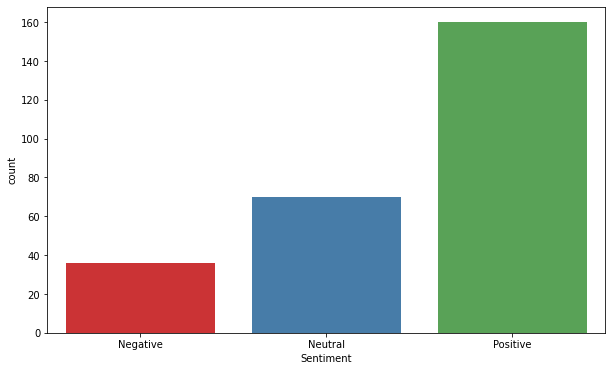

In [14]:
fig = plt.figure(figsize=(10,6))
sns.countplot(x='Sentiment', data=dataset, palette='Set1', order=['Negative', 'Neutral', 'Positive'])

The data exploration clearly indicates that the data is **unbalanced**

### Data Cleaning / Text Processing

#### Convert text to lower case

In [15]:
def convert_to_lower_case(text):
    return " ".join(text.lower() for text in text.split())

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: convert_to_lower_case(sentence))

#### Check if the sentences have been lower-cased

In [16]:
dataset.head(2)

,Sentence,Positive,Negative,Neutral,Sentiment
ID,,,,,
1,the results in 2nd line treatment show an orr ...,1,0,0,Positive
2,the long duration of response and high durable...,1,0,0,Positive


#### Remove punctuations

##### An example sentence before removing punctuation

In [17]:
dataset['Sentence'][7]

'this medicinal product has been authorised under a so-called ‘conditional approval’ scheme'

In [18]:
def remove_punctuations(text):
    return re.sub(r'[^\w\s]','',text)

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: remove_punctuations(sentence))

##### Check if the punctuations from a specific sentence with punctuation have been removed

In [19]:
# The same sentence after removing punctuation
dataset['Sentence'][7]

'this medicinal product has been authorised under a socalled conditional approval scheme'

#### Fix misspelled words if any

It is not expected to have any spelling mistakes in the EPARs. However, one small spelling mistake is found which is corrected below.

Libraries like `TextBlob` can be used to find the spelling mistakes and correct them automatically. But, it will lead to further problems since pharmaceutical
terminologies don't exist in `TextBlob`'s english corpus. Hence, auto-correction hasn't been applied.

However, as a precaution, the data has been copied as text and manually reviewed on online spell checker to find out about any spelling mistake.

##### The sentence with wrong spelling of `profile` -> `proflie`

In [20]:
dataset['Sentence'][29]

'although dataset of afl patients has been updated data are still considered very limited to reach firm conclusion about safety proflie'

In [21]:
def fix_misspelled_words(text):
    mispelled_dict = {'proflie': 'profile'}

    for word in mispelled_dict.keys():
        text = text.replace(word, mispelled_dict[word])
    return text

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: fix_misspelled_words(sentence))

##### The above sentence with spelling mistake has been fixed
`proflie` is corrected to `profile`

In [22]:
dataset['Sentence'][29]

'although dataset of afl patients has been updated data are still considered very limited to reach firm conclusion about safety profile'

#### Remove stopwords

In [23]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(text):
    return " ".join(x for x in text.split() if x not in stop_words)

dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: remove_stopwords(sentence))

[nltk_data] Downloading package stopwords to /Users/amit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Check if the stopwords have been removed from a specific sentence containing stopwords

In [24]:
dataset['Sentence'][1]

'results 2nd line treatment show orr 33 patients durable responses resulting apparent pfs plateau'

#### Lemmatization
##### Not used (refer to the following reasoning)

#### Disable unnecessary pipelines to speed up

In [25]:
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
# def lemmatise(text):
#   doc = nlp(text)
#   return " ".join([token.lemma_ for token in doc])

Using lemmatization or stemming in the sentiment analysis is debatable topic.
Though it has advantages in mainly reducing the noise, it may break
the parts of speech tagging or alter the polarity of the word.

In [27]:
# dataset['Sentence'] = dataset['Sentence'].apply(lambda sentence: lemmatise(sentence))

#### Features and Labels

In [28]:
X = dataset['Sentence']
y = dataset['Sentiment']

#### Encode target labels in the Sentiment column for multi-class text classification

In [29]:
le = LabelEncoder()
y = le.fit_transform(y)

#### List the target classes and associated labels from the encoder

In [30]:
# target labels with value between 0 and n_classes-1 from left to right
list(le.classes_)

['Negative', 'Neutral', 'Positive']

#### TF-IDF Vectorizer

In [31]:
vectorizer = TfidfVectorizer(max_features=2500, max_df=0.8, min_df=4)
X = vectorizer.fit_transform(X)

#### Train test split with result reproducibility using specified random state

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

The plan is to implement few classical machine learning classifiers to check the accuracy of the model.
Since all classical machine learning classifiers can share the same base imlementation, in this
notebook, we are going to implement only one or two classical machine learning classifier(s) and the rest of the
implementations will be available in the source code as python files.

#### Support Vector Machine Classifier (SVC)

#### Define the SVC (linear kernel)

In [33]:
classifier_svc = SVC(kernel = 'linear')

#### Fit the SVC (linear kernel) on the training data

In [34]:
classifier_svc.fit(X_train, y_train)

SVC(kernel='linear')

#### Prediction on the test data

In [35]:
svc_pred = classifier_svc.predict(X_test)

#### Evaluation Matrices

##### Confusion Matrix

In [36]:
cm = confusion_matrix(y_test, svc_pred)
print(cm)

[[ 1  2  4]
 [ 0  5 11]
 [ 0  1 30]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

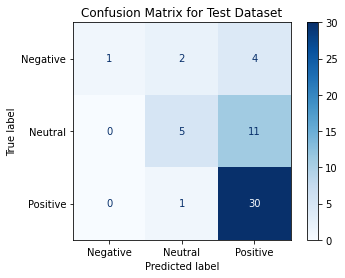

In [37]:
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')

##### Classification Report

In [38]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.62      0.31      0.42        16
           2       0.67      0.97      0.79        31

    accuracy                           0.67        54
   macro avg       0.76      0.47      0.49        54
weighted avg       0.70      0.67      0.61        54



##### Accuracy Score

In [39]:
print(accuracy_score(y_test, svc_pred))

0.6666666666666666


#### Apply k-Fold Cross-validation

Generally for small datasets, k-Fold cross-validation is used instead of train-test-split/holdout validation.
The holdout validation is primarily useful for larger datasets.

Since we have only 266 data points, it is useful to apply k-Fold cross-validation as we will then
be able to perform predictions on all of our data by building `K` different models.

The number 36 for cross-validation denotes that k-folds will be used with 36 splits.

The number 36 has been chosen since sklearn generates warning for any
value greater than 36. According to stratify K-folds, the warning gets
generated if the number of elements in the least populated class is
less than the number of splits. In our dataset, the least populated
class (Negative labelled) contains 36 items (sentences) and that's why
36 has been chosen as the number of splits in K-folds.

In [40]:
accuracies = cross_val_score(estimator = classifier_svc, X = X, y = y, cv = 36)

#### Mean accuracy score

In [41]:
print(f"{accuracies.mean() * 100:.2f}%")

68.60%


#### Apply Leave-one-out Cross-validation

An extented version of k-fold cross-validation that same no. of splits as the no. of data points.
This is also considered to be very useful for small datasets.

In [42]:
accuracies = cross_val_score(estimator = classifier_svc, X = X, y = y, cv = LeaveOneOut() )

#### Mean accuracy score

In [43]:
print(f"{accuracies.mean() * 100:.2f}%")

69.55%


#### Grid Search (k-fold cross-validation)
Used to tune the hyperparameters in order to find the best performing model

In [44]:
parameters = [
        {
            'C': [1, 10, 100, 1000],
            'kernel': ['linear']
        },
        {
            'C': [1, 10, 100, 1000],
            'kernel': ['rbf'],
            'gamma': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        }
]

In [45]:
grid_search = GridSearchCV(estimator = SVC(kernel = 'rbf', random_state = 0),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 36,
                           n_jobs = -1)
grid_search.fit(X, y)

GridSearchCV(cv=36, estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                    0.7, 0.8, 0.9],
                          'kernel': ['rbf']}],
             scoring='accuracy')

#### Best Accuracy

In [46]:
best_accuracy = grid_search.best_score_
print(f"{best_accuracy*100:.2f}%")

71.58%


#### Best Parameters

In [47]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'C': 10, 'gamma': 0.9, 'kernel': 'rbf'}


#### Grid Search (Leave-one-out cross-validation)

In [48]:
grid_search = GridSearchCV(estimator = SVC(kernel = 'rbf'),
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = LeaveOneOut(),
                           n_jobs = -1)
grid_search.fit(X, y)

GridSearchCV(cv=LeaveOneOut(), estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000],
                          'gamma': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                    0.7, 0.8, 0.9],
                          'kernel': ['rbf']}],
             scoring='accuracy')

#### Best Accuracy

In [49]:
best_accuracy = grid_search.best_score_
print(f"{best_accuracy*100:.2f}%")

73.68%


#### Best Parameters

In [50]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'C': 10, 'gamma': 0.9, 'kernel': 'rbf'}


#### SVC(kernel='linear') vs LinearSVC

#### Linear Support Vector Classifier

Since by default, `LinearSVC` minimizes the squared hinge loss
in comparison with SVC with a linear kernel that minimizes the regular
hinge loss, the `LinearSVC` may perform differently.

In [51]:
classifier_svc_lin = LinearSVC()
classifier_svc_lin.fit(X_train, y_train)
svc_lin_pred = classifier_svc_lin.predict(X_test)

#### Classification Report

In [52]:
print(classification_report(y_test, svc_lin_pred))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.58      0.44      0.50        16
           2       0.75      0.87      0.81        31

    accuracy                           0.70        54
   macro avg       0.67      0.63      0.64        54
weighted avg       0.69      0.70      0.69        54



#### Confusion Matrix

[[ 4  1  2]
 [ 2  7  7]
 [ 0  4 27]]


Text(0.5, 1.0, 'Confusion Matrix for Test Dataset')

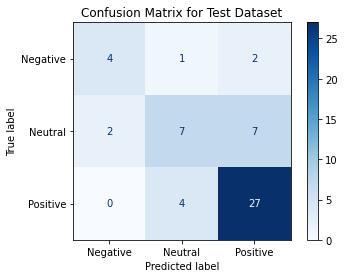

In [53]:
cm = confusion_matrix(y_test, svc_lin_pred)
print(cm)

cm_display = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])
cm_display.plot(cmap = 'Blues')
plt.title('Confusion Matrix for Test Dataset')


#### Accuracy Score

In [54]:
print(accuracy_score(y_test, svc_lin_pred))

0.7037037037037037


#### Classification Report

In [55]:
print(classification_report(y_test, svc_lin_pred))

              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.58      0.44      0.50        16
           2       0.75      0.87      0.81        31

    accuracy                           0.70        54
   macro avg       0.67      0.63      0.64        54
weighted avg       0.69      0.70      0.69        54



#### Calculate k-fold cross-validation accuracies for `LinearSVC` classifier

In [56]:
accuracies = cross_val_score(
                estimator = LinearSVC(),
                X = X,
                y = y,
                cv = 36)

#### Mean Accuracy

In [57]:
print(f"{accuracies.mean() * 100:.2f}%")

68.25%


#### Calculate leave-one-out cross-validation accuracies for `LinearSVC` classifier

In [58]:
accuracies = cross_val_score(
                estimator = LinearSVC(),
                X = X,
                y = y,
                cv = LeaveOneOut())

#### Mean Accuracy

In [59]:
print(f"{accuracies.mean() * 100:.2f}%")

71.43%


### Conclusion

So far the following classifiers have been evaluated:

* Support Vector Machine with Gaussian and Linear Kernels
* Linear Support Vector

In the first case, even though the linear kernel SVC results in lower accuracy
than the gaussian kernel, it was still worth to look at the linear SVC model
that uses different loss function than the SVC with linear kernel. And, the test for the
linear SVC resulted in better performance considering `f1 score`, `precision` and
`recall` for imbalanced dataset in terms of negative and neutral
sentiments.

In the python sources, one can test many other classical machine learning
classifiers as well as `Bidirectional Long Short Term Memory (LSTM)
Recurrent Neural Network (RNN)` deep learning model.